# Investigate which Architecture is Optimal for the Dataset
Examining the number of layers, number of nodes per layer and other hyperparameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState, MT19937, SeedSequence
import pandas as pd
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping

## Constraints
- Activation function for hidden layers will be set to `relu`

In [2]:
params = {
    'random_state': 42,
    'min_hidden_layers': 0,
    'max_hidden_layers': 3,
    'min_nodes_per_hidden_layer': 5,
    'max_nodes_per_hidden_layer': 20,
    'min_dropout_rate': 0.0,
    'max_dropout_rate': 0.5,
    'min_learning_rate': -3,
    'max_learning_rate': -1,
    'num_epochs': 500,
    'batch_size': 32,
}

rs = RandomState(MT19937(SeedSequence(params['random_state'])))

In [3]:
df_heart = pd.read_csv('data/heart_failure_clinical_records_dataset.xls')

In [4]:
df_heart.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
X = df_heart.drop(columns='DEATH_EVENT')
y = df_heart['DEATH_EVENT']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=params['random_state'], stratify=y
)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Define the Model

Functions

In [8]:
def define_model_structure_randomly(
    layer_range: list[int],
    nodes_per_layer_range: list[int],
):
    if nodes_per_layer_range.min() < 1:
        raise ValueError("Minimum nodes per layer must be >= 1")
    # Set number of layers in structure, weighted so the first (zero layers) appears less often
    structure = np.zeros((np.random.choice(layer_range, p=[0.1, 0.3, 0.3, 0.3])), dtype=float)
    for layer in range(structure.size):
        # Set number of nodes in layer
        structure[layer] = np.random.choice(nodes_per_layer_range)
    return structure


def add_hidden_layers(
    model: models.Sequential,
    structure,
    activation: str = 'relu',
    dropout_rate: float = 0.0
):
    for layer in structure:
        model.add(layers.Dense(layer, activation=activation))
        model.add(layers.Dropout(dropout_rate))



Hyperparameter Distributions

In [9]:
hidden_layer_range = np.arange(
    params['min_hidden_layers'],
    params['max_hidden_layers'] + 1,
    step=1
)
nodes_per_layer_range = np.arange(
    params['min_nodes_per_hidden_layer'],
    params['max_nodes_per_hidden_layer'] + 1,
    step=1
)
dropout_range = np.linspace(
    params['min_dropout_rate'],
    params['max_dropout_rate'],
    num=6
)
learning_rate_range = np.logspace(
    params['min_learning_rate'],
    params['max_learning_rate'],
    num=10
)

Define & Compile a Model

In [10]:
# Define the model's hyperparameters
input_size = (X.columns.size,)
structure = define_model_structure_randomly(
    hidden_layer_range,
    nodes_per_layer_range
)
dropout = np.random.choice(dropout_range)
learning_rate = np.random.choice(learning_rate_range)

# Create the model
model = models.Sequential()
model.add(layers.Input(input_size))
add_hidden_layers(model, structure, dropout_rate=dropout)
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate),
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc'),
    ]
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                234       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 19        
                                                                 
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


## Fit the model

Define early stopping conditions

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, min_delta=1e-6, patience=3
)

In [13]:
history = model.fit(
    X_train,
    y_train,
    epochs=params['num_epochs'],
    batch_size=params['batch_size'],
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/500


6/6 [==============================] - 1s 80ms/step - loss: 0.9283 - accuracy: 0.3631 - precision: 0.2846 - recall: 0.6379 - auc: 0.4475 - val_loss: 0.9335 - val_accuracy: 0.3333 - val_precision: 0.2333 - val_recall: 0.5000 - val_auc: 0.3399
Epoch 2/500
6/6 [==============================] - 0s 7ms/step - loss: 0.9392 - accuracy: 0.3017 - precision: 0.2481 - recall: 0.5690 - auc: 0.4135 - val_loss: 0.9176 - val_accuracy: 0.3333 - val_precision: 0.2333 - val_recall: 0.5000 - val_auc: 0.3456
Epoch 3/500
6/6 [==============================] - 0s 7ms/step - loss: 0.8772 - accuracy: 0.3631 - precision: 0.2812 - recall: 0.6207 - auc: 0.4840 - val_loss: 0.9031 - val_accuracy: 0.3556 - val_precision: 0.2414 - val_recall: 0.5000 - val_auc: 0.3571
Epoch 4/500
6/6 [==============================] - 0s 7ms/step - loss: 0.8787 - accuracy: 0.3911 - precision: 0.2893 - recall: 0.6034 - auc: 0.4533 - val_loss: 0.8892 - val_accuracy: 0.3556 - val_precision: 0.2414 - val_recall: 0.5000 - val_auc: 0.3618

## Plot the Results

In [14]:
def plot_epochs(variable: str):
    plt.plot(history.history[variable])
    plt.plot(history.history['val_' + variable])
    plt.title(f'Model {variable.capitalize()} Across Training Epochs')
    plt.ylabel(variable.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

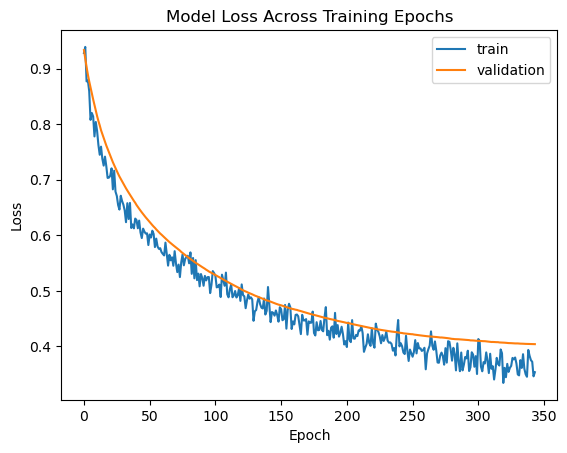

In [15]:
plot_epochs('loss')

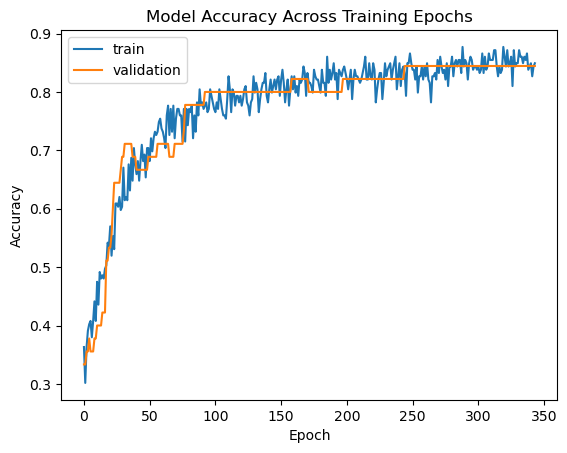

In [16]:
plot_epochs('accuracy')

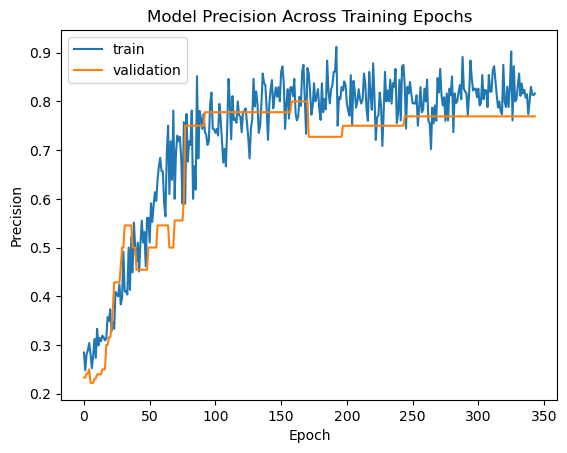

In [17]:
plot_epochs('precision')

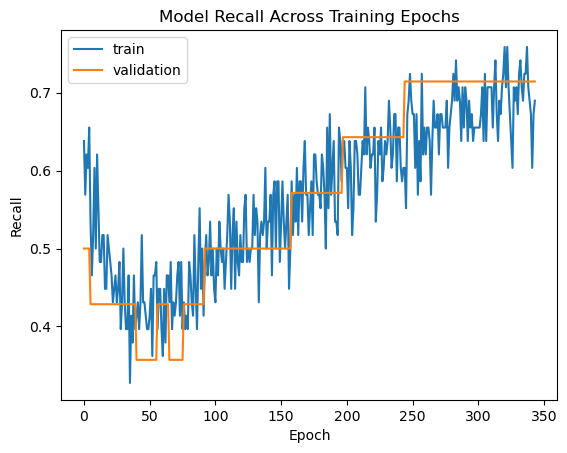

In [18]:
plot_epochs('recall')

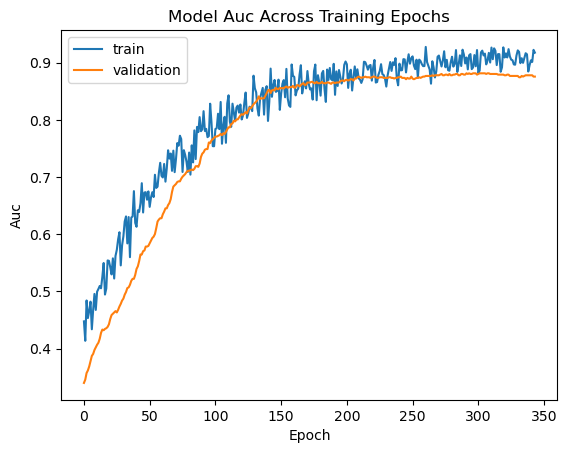

In [19]:
plot_epochs('auc')

## Track Parameters

In [20]:
def add_structure_to_params(params: dict, structure):
    for l in range(params['max_hidden_layers']):
        if l < structure.size:
            num_nodes = int(structure[l])
        else:
            num_nodes = np.NaN
        params[f'layer_{l}'] = num_nodes

In [21]:
params['num_epochs'] = len(history.history['loss'])
params['num_hidden_layers'] = structure.size
add_structure_to_params(params, np.array(structure))
params['dropout'] = dropout
params['learning_rate'] = learning_rate
params['num_params'] = model.count_params()

In [22]:
for k, v in params.items():
    print(f'{k}: {v}')

random_state: 42
min_hidden_layers: 0
max_hidden_layers: 3
min_nodes_per_hidden_layer: 5
max_nodes_per_hidden_layer: 20
min_dropout_rate: 0.0
max_dropout_rate: 0.5
min_learning_rate: -3
max_learning_rate: -1
num_epochs: 344
batch_size: 32
num_hidden_layers: 1
layer_0: 18
layer_1: nan
layer_2: nan
dropout: 0.2
learning_rate: 0.007742636826811269
num_params: 253
